<a href="https://colab.research.google.com/github/caroldaza/DM_CyT/blob/main/smallworldofwords_v6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import sys
sys.path.append('/content/drive/MyDrive/')

In [220]:
import time
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
sns.set_context('poster')
mpl.rcParams['figure.figsize'] = (8,6)

import numpy as np
import pandas as pd   

!pip install networkx powerlaw community

import networkx as nx
import community
import powerlaw
from gensim import corpora, models, similarities, matutils
from gensim.models.word2vec import Word2Vec
from gensim.models import KeyedVectors

from sklearn.metrics import adjusted_rand_score

from networkx.algorithms.community import modularity
import community.community_louvain as community_louvain
from networkx.algorithms.community.centrality import girvan_newman


In [4]:
filename = '/content/drive/MyDrive/SWOW-EN.R100.csv.zip'
datos = pd.read_csv(filename, sep=',')
datos.head()

,Unnamed: 0,id,participantID,age,gender,nativeLanguage,country,education,created_at,cue,R1,R2,R3
0,1,29,3,33,Fe,United States,Australia,NaN,2011-08-12 02:19:38,although,nevertheless,yet,but
1,2,30,3,33,Fe,United States,Australia,NaN,2011-08-12 02:19:38,deal,no,cards,shake
2,3,31,3,33,Fe,United States,Australia,NaN,2011-08-12 02:19:38,music,notes,band,rhythm
3,4,32,3,33,Fe,United States,Australia,NaN,2011-08-12 02:19:38,inform,tell,rat on,NaN
4,5,33,3,33,Fe,United States,Australia,NaN,2011-08-12 02:19:38,way,path,via,method


Filtrando por edad

In [5]:
edad=[30,40]
data_filt1 = datos[datos.age.isin(edad)]
data_filt1.shape

(54277, 13)

Filtrando por pais

In [6]:
data_filt2 = data_filt1[data_filt1['nativeLanguage']=='United States']
data_filt2.shape

(26516, 13)

Filtrando por idioma

In [7]:
data_filt3 = data_filt2[data_filt2['country']=='United States']
data_filt3.shape

(24151, 13)

In [8]:
# Nos quedamos solo con la cue y la primera palabra. Tambien botamos Nans
data = data_filt3.loc[:,['cue','R1']]
data = data.dropna(how='any')

# Sacar palabras de una letra
data.drop(data[data['cue'].str.len().lt(2)].index, inplace=True)
data.drop(data[data['R1'].str.len().lt(2)].index, inplace=True)

data.head()

,cue,R1
990,supply,give
991,raise,up
992,no,yes
993,likely,will
994,up,down


In [9]:
data.shape[0]

23853

In [10]:
# ¿Cuántas claves y respuestas son únicas?
print(data['cue'].unique().shape)
print(data['R1'].unique().shape)

(10412,)
(7947,)


In [11]:
# ¿cuántas palabras de R1 están en Cue? ¿alrevés?
print(sum(data['R1'].isin(data['cue'].unique())))
print(sum(data['cue'].isin(data['R1'].unique())))

18468
11695


In [12]:
# Sacar palabras que no este en cue Y en R1
data.drop(data[data['R1'].isin(data['cue'].unique())==False].index, inplace=True)
data.drop(data[data['cue'].isin(data['R1'].unique())==False].index, inplace=True)

In [13]:
data.shape[0]

9160

In [14]:
# la frecuencia de cada cue
new_df = data['cue'].str.split(expand=True).stack().value_counts().reset_index()
new_df.columns = ['Word', 'Frequency'] 

In [15]:
new_df.head(5)

,Word,Frequency
0,games,9
1,tummy,9
2,up,8
3,bed,8
4,snapshot,8


Text(0, 0.5, 'frequency')

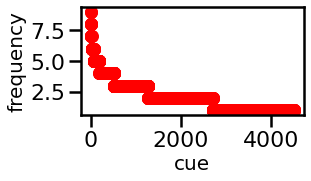

In [16]:
f = plt.figure()
f.set_figwidth(4)
f.set_figheight(2)
plt.plot(new_df['Frequency'],'ro')
plt.xlabel("cue",fontsize=20)
plt.ylabel("frequency",fontsize=20)

Text(0, 0.5, 'frequency')

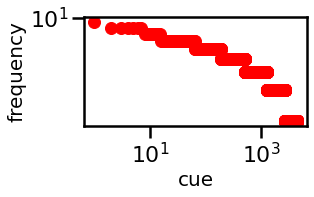

In [17]:
#plt.loglog(np.linspace(1, len(new_df['Frequency']),len(new_df['Frequency'])),new_df['Frequency'].to_numpy())
f = plt.figure()
f.set_figwidth(4)
f.set_figheight(2)
plt.yscale('log')
plt.xscale('log')
plt.plot(new_df['Frequency'],'ro')
plt.xlabel("cue",fontsize=20)
plt.ylabel("frequency",fontsize=20)

In [18]:
# la frecuencia de cada R1
new_df_R1 = data['R1'].str.split(expand=True).stack().value_counts().reset_index()
new_df_R1.columns = ['Word', 'Frequency'] 

Text(0, 0.5, 'frequency')

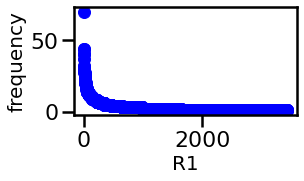

In [19]:
f = plt.figure()
f.set_figwidth(4)
f.set_figheight(2)
plt.plot(new_df_R1['Frequency'],'bo')
plt.xlabel("R1",fontsize=20)
plt.ylabel("frequency",fontsize=20)

Text(0, 0.5, 'frequency')

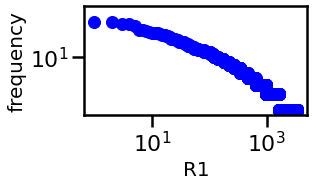

In [20]:
f = plt.figure()
f.set_figwidth(4)
f.set_figheight(2)
plt.yscale('log')
plt.xscale('log')
plt.plot(new_df_R1['Frequency'],'bo')
plt.xlabel("R1",fontsize=20)
plt.ylabel("frequency",fontsize=20)

In [21]:
# calculando frecuencia de aparicion de cada cue
df1 = data.groupby(['cue']).size().to_frame(name='size').reset_index()
df1_sorted = df1.sort_values(by=['size'],ascending=False).reset_index()
df1_sorted.head(5)

,index,cue,size
0,4186,tummy,9
1,207,aged,8
2,462,bed,8
3,3985,task,8
4,4516,zebra,8


In [22]:
df1.shape

(4523, 2)

In [23]:
# calculando frecuencia de aparicion de R1
df3 = data.groupby(['R1']).size().to_frame(name='size').reset_index()
df3_sorted = df3.sort_values(by=['size'],ascending=False).reset_index()
df3_sorted.head(5)

,index,R1,size
0,1960,money,70
1,3303,water,44
2,1255,food,44
3,1826,love,40
4,2650,sex,40


In [24]:
# calculando frecuencia de aparicion de cada par cue-R1
df2 = data.groupby(['cue','R1']).size().to_frame(name='size').reset_index()
df2_sorted = df2.sort_values(by=['size'],ascending=False).reset_index()
df2_sorted.head(5)

,index,cue,R1,size
0,3054,fork,spoon,6
1,4084,knob,door,5
2,517,apologize,sorry,5
3,5932,repair,fix,5
4,3376,grizzly,bear,4


In [25]:
df2.shape

(8075, 3)

In [26]:
# Merge
df = df2.merge(df1,left_on='cue',right_on='cue')
df = df.rename(columns={'size_x':'frec_par','size_y':'frec_cue'})
df['frec'] = df['frec_par']/df['frec_cue']
df.head(5)

,cue,R1,frec_par,frec_cue,frec
0,Africa,continent,2,2,1.000000
1,Amazon,books,1,3,0.333333
2,Amazon,cheap,1,3,0.333333
3,Amazon,shopping,1,3,0.333333
4,America,freedom,1,1,1.000000


In [27]:
df_0 = df

In [28]:
#sacando los duplicados
#df_auxy = df[df.duplicated()]
#print(df_auxy.shape[0])

distribuciones de frecuencias despues de limpiar datos

Text(0, 0.5, 'frequency')

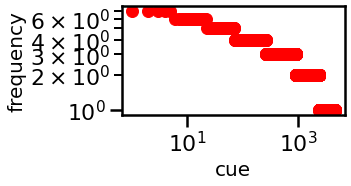

In [29]:
auxc = df['cue'].str.split(expand=True).stack().value_counts().reset_index()
auxc.columns = ['Word', 'Frequency'] 
f = plt.figure()
f.set_figwidth(4)
f.set_figheight(2)
plt.yscale('log')
plt.xscale('log')
plt.plot(auxc['Frequency'],'ro')
plt.xlabel("cue",fontsize=20)
plt.ylabel("frequency",fontsize=20)

Text(0, 0.5, 'frequency')

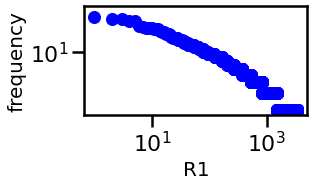

In [30]:
auxp = df['R1'].str.split(expand=True).stack().value_counts().reset_index()
auxp.columns = ['Word', 'Frequency'] 
f = plt.figure()
f.set_figwidth(4)
f.set_figheight(2)
plt.yscale('log')
plt.xscale('log')
plt.plot(auxp['Frequency'],'bo')
plt.xlabel("R1",fontsize=20)
plt.ylabel("frequency",fontsize=20)

In [31]:
# Recortando el grafo

df = df[df['frec']>0.025]
df.shape

(8075, 5)

In [32]:
# Sacar palabras R1 que no estan en cue y cue que no estan en R1, otra vez
df.drop(df[df['R1'].isin(df['cue'].unique())==False].index, inplace=True)
df.drop(df[df['cue'].isin(df['R1'].unique())==False].index, inplace=True)
print(df.shape[0])

5250


El grafo:

In [33]:
G1= nx.from_pandas_edgelist(df[['cue','R1','frec']],source='cue',target='R1',edge_attr='frec',create_using=nx.DiGraph())

In [34]:
G1.is_directed()

True

In [35]:
nx.is_weighted(G1)

False

Aca comentar que es un bug de la funcion que no toma los atributos, pero que es pesado

Text(0.5, 1.0, 'spring')

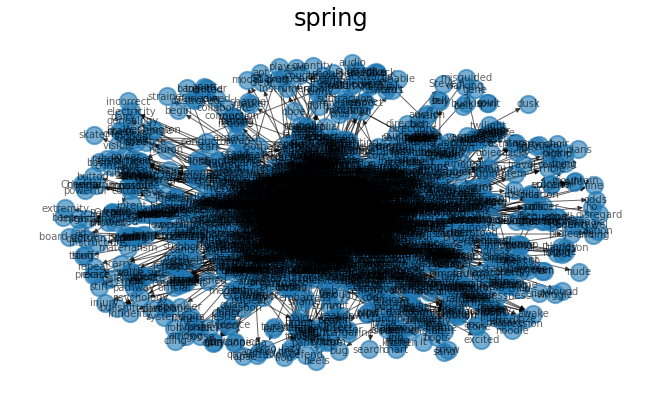

In [36]:
#Visualizando la red

plt.figure(figsize=(9,5))

#plt.subplot(131)
nx.draw(G1, with_labels=True,font_size=10,alpha=0.6)
plt.title('spring')

#plt.subplot(132)
#layout=nx.fruchterman_reingold_layout(G1)
#nx.draw(G1,layout, with_labels=True, font_weight='bold')
#plt.title('fruchterman reingold')

#plt.subplot(133)
#layout=nx.circular_layout(G1)
#nx.draw(G1,layout, with_labels=True, font_weight='bold')
#plt.title('circular');

Text(0.5, 1.0, 'fruchterman reingold')

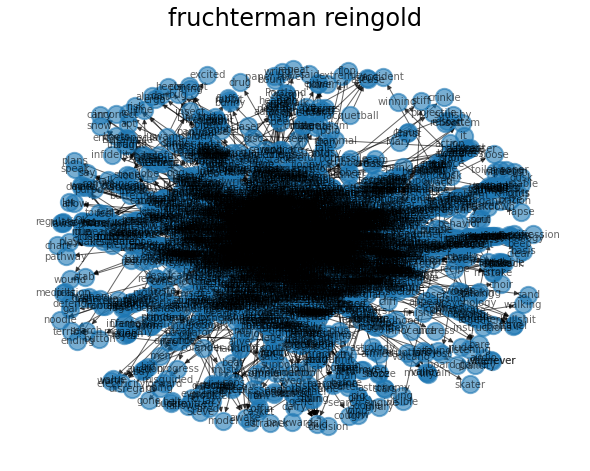

In [37]:
layout=nx.fruchterman_reingold_layout(G1)
nx.draw(G1,layout, with_labels=True,font_size=10,alpha=0.6)
plt.title('fruchterman reingold')

In [38]:
df1_1 = df[['cue']].rename(columns={'cue':'word'},inplace=False) #dejando solo la palabra
df2_1 = df[['R1']].rename(columns={'R1':'word'},inplace=False)

df_dict_1 = pd.concat([df1_1,df2_1])  # concatenando
list_dict_1 = df_dict_1['word'].unique() #eliminando duplicados
list_dict_1.shape

(3109,)

In [39]:
print('numero nodos',len(list_dict_1))
print('numero maximo aristas (no dirigidas y sin loops)',len(list_dict_1)*(len(list_dict_1)-1)/2)
print('numero maximo aristas (dirigidas y sin loops)',len(list_dict_1)*(len(list_dict_1)-1))
print('numero maximo aristas (dirigidas y con loops)',len(list_dict_1)*(len(list_dict_1)))

numero nodos 3109
numero maximo aristas (no dirigidas y sin loops) 4831386.0
numero maximo aristas (dirigidas y sin loops) 9662772
numero maximo aristas (dirigidas y con loops) 9665881


Histograma sobre los pesos de las aristas (tomados como las frecuencias de las parejas):

Text(0.5, 1.0, 'Histograma aristas Gsww')

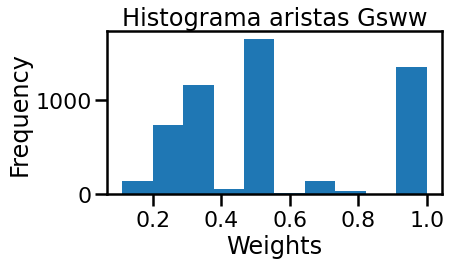

In [40]:
f = plt.figure()
f.set_figwidth(6)
f.set_figheight(3)
plt.hist(df['frec'],bins=10)
plt.ylabel('Frequency')
plt.xlabel('Weights');
plt.title('Histograma aristas Gsww')

Esta fue la red sin sacar las palabras de w2v

# Comparando con las palabras de word2vec

In [41]:
# cargamos word2vec
!wget https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz

w2v_model2 = KeyedVectors.load_word2vec_format('./GoogleNews-vectors-negative300.bin.gz', binary=True)

--2021-12-13 05:15:20--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.172.48
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.172.48|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1647046227 (1.5G) [application/x-gzip]
Saving to: ‘GoogleNews-vectors-negative300.bin.gz’

GoogleNews-vectors- 100%[===================>]   1.53G  38.5MB/s    in 31s     

2021-12-13 05:15:51 (51.5 MB/s) - ‘GoogleNews-vectors-negative300.bin.gz’ saved [1647046227/1647046227]



In [145]:
# sacar palabras que no esten en w2v
l = [w for w in data['cue'] if w not in w2v_model2.vocab]
df_w2v = data[-data['cue'].isin(l)]
print(df_w2v.shape[0]) 

9027


In [146]:
l = [w for w in df_w2v['R1'] if w not in w2v_model2.vocab]
df_w2v = df_w2v[-df_w2v['R1'].isin(l)]
print(df_w2v.shape[0])

8970


In [147]:
df_w2v.head(5)

,cue,R1
991,raise,up
992,no,yes
993,likely,will
994,up,down
995,answer,question


In [148]:
# Sacar palabras R1 que no estan en cue y cue que no estan en R1, otra vez
df_w2v.drop(df_w2v[df_w2v['R1'].isin(df_w2v['cue'].unique())==False].index, inplace=True)
df_w2v.drop(df_w2v[df_w2v['cue'].isin(df_w2v['R1'].unique())==False].index, inplace=True)
print(df_w2v.shape[0])

5812


#Frecuencia de aparicion de pares

In [149]:
# calculando frecuencia de aparicion de cada cue
df1_2 = df_w2v.groupby(['cue']).size().to_frame(name='size').reset_index()
df1_2_sorted = df1_2.sort_values(by=['size'],ascending=False).reset_index()
df1_2_sorted.head(5)

,index,cue,size
0,2706,tummy,9
1,125,aged,8
2,2366,snapshot,8
3,2571,task,8
4,2935,zebra,8


In [150]:
# calculando frecuencia de aparicion de cada par cue-R1
df2_2 = df_w2v.groupby(['cue','R1']).size().to_frame(name='size').reset_index()
df2_2_sorted = df2_2.sort_values(by=['size'],ascending=False).reset_index()
df2_2_sorted.head(5)

,index,cue,R1,size
0,1941,fork,spoon,6
1,3728,repair,fix,5
2,2598,knob,door,5
3,1559,dumb,stupid,4
4,1076,companion,friend,4


In [151]:
# merge
df_2 = df2_2.merge(df1_2,left_on='cue',right_on='cue')
df_2 = df_2.rename(columns={'size_x':'frec_par','size_y':'frec_cue'})
df_2['frec'] = df_2['frec_par']/df_2['frec_cue']
df_2.head(5)

,cue,R1,frec_par,frec_cue,frec
0,America,freedom,1,1,1.00
1,American,ignorant,1,4,0.25
2,American,people,1,4,0.25
3,American,pie,1,4,0.25
4,American,words,1,4,0.25


In [152]:
df_2.shape

(5113, 5)

In [154]:
# Recortando el grafo

df_2 = df_2[df_2['frec']>0.25]
df_2.shape

(4372, 5)

In [155]:
df11_2 = df_2[['cue']].rename(columns={'cue':'word'},inplace=False) #dejando solo la palabra
df22_2 = df_2[['R1']].rename(columns={'R1':'word'},inplace=False)

df_dict_2 = pd.concat([df11_2,df22_2])  # concatenando
list_dict_2 = df_dict_2['word'].unique() #eliminando duplicados
list_dict_2.shape

(3012,)

In [156]:
print('numero nodos',len(list_dict_2))
print('numero maximo aristas (no dirigidas y sin loops)',len(list_dict_2)*(len(list_dict_2)-1)/2)
print('numero maximo aristas (dirigidas y sin loops)',len(list_dict_2)*(len(list_dict_2)-1))
print('numero maximo aristas (dirigidas y con loops)',len(list_dict_2)*(len(list_dict_2)))

numero nodos 3012
numero maximo aristas (no dirigidas y sin loops) 4534566.0
numero maximo aristas (dirigidas y sin loops) 9069132
numero maximo aristas (dirigidas y con loops) 9072144


In [157]:
df_2.shape

(4372, 5)

Text(0.5, 1.0, 'Histograma aristas Gw2v')

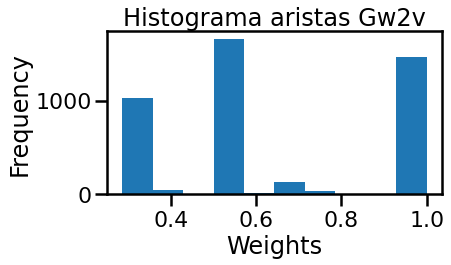

In [159]:
f = plt.figure()
f.set_figwidth(6)
f.set_figheight(3)
plt.hist(df_2['frec'],bins=10)
plt.ylabel('Frequency')
plt.xlabel('Weights');
plt.title('Histograma aristas Gw2v')

#Distancias matrices w2v

Hacemos la matriz de distancias de todas contra todas

In [114]:
distancias_w2v_dict=np.zeros((len(list_dict_2),len(list_dict_2))) #matriz cuadrada
t = time.time()
print('Total de pares de palabras %d'%(len(list_dict_2)*(len(list_dict_2)-1)/2))
for i,ti in enumerate(list_dict_2):
  if i % 1000 ==0:
    print('Palabra %d: %.2f secs'%(i,time.time()-t))
  for j,tj in enumerate(list_dict_2):
    if j>i:
      distancias_w2v_dict[i,j] = abs(1-w2v_model2.similarity(ti,tj))


Total de pares de palabras 4534566
Palabra 0: 0.00 secs
Palabra 1000: 61.54 secs
Palabra 2000: 99.10 secs
Palabra 3000: 112.29 secs


In [115]:
distancias_w2v_dict = distancias_w2v_dict + distancias_w2v_dict.T
print(distancias_w2v_dict.shape)

(3012, 3012)


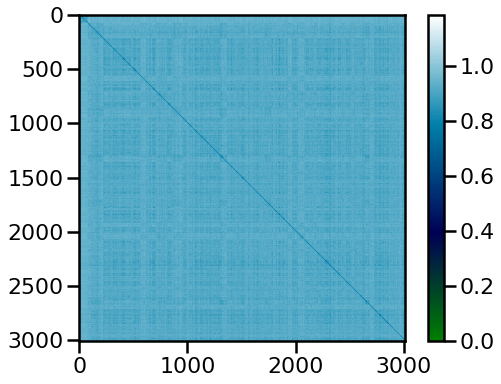

In [116]:
plt.imshow(distancias_w2v_dict,cmap='ocean')
plt.colorbar()

Son muchos elementos, pero haciendo un zoom, se ven algunas pequeñas comunidades muy locales

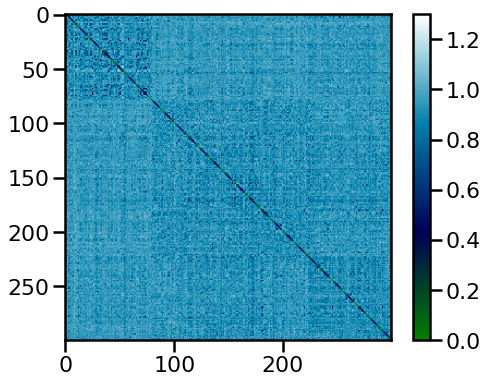

In [117]:
distancia_peque = distancias_w2v_dict[0:300,0:300]
plt.imshow(distancia_peque,cmap='ocean',vmax=1.3,vmin=0)
plt.colorbar()

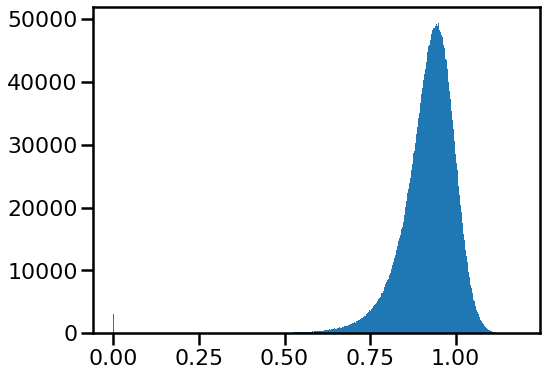

In [118]:
#El histograma de distancias
out = plt.hist(distancias_w2v_dict.flatten(),bins='auto')


El grafo:

In [160]:
G2= nx.from_pandas_edgelist(df_2[['cue','R1','frec']],source='cue',target='R1',edge_attr='frec')

In [161]:
G2.is_directed()

False

In [162]:
nx.is_weighted(G2)

False

A pesar de darle pesos a las conexiones la funcion que hace el grafo no las ve

Text(0.5, 1.0, 'spring')

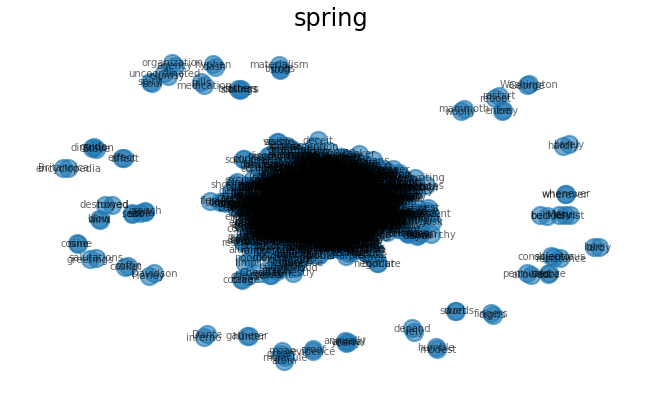

In [122]:
#Visualizando la red

plt.figure(figsize=(9,5))

#plt.subplot(131)
nx.draw(G2, with_labels=True,font_size=10,alpha=0.6)
plt.title('spring')

#plt.subplot(132)
#layout=nx.fruchterman_reingold_layout(G2)
#nx.draw(G2,layout, with_labels=True, alpha=0.6)
#plt.title('fruchterman reingold')

#plt.subplot(133)
#layout=nx.circular_layout(G2)
#nx.draw(G2,layout, with_labels=False,alpha=0.6)
#plt.title('circular');

Text(0.5, 1.0, 'fruchterman reingold')

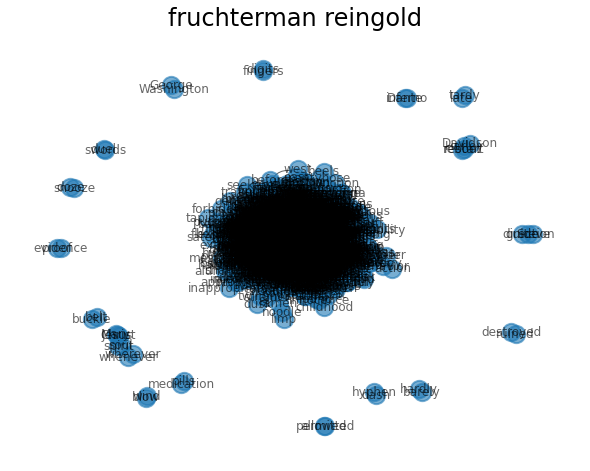

In [66]:
layout=nx.fruchterman_reingold_layout(G2)
nx.draw(G2,layout, with_labels=True, alpha=0.6)
plt.title('fruchterman reingold')

No hubo manera que dibuje las aristas...

# Caracterizacion de los grafos

Red G_sww (G1)

Es pesada la red?

In [163]:
print(nx.info(G1))
print('Is weigthed:',nx.is_weighted(G1))

G1.number_of_nodes(), G1.number_of_edges()

DiGraph with 3109 nodes and 5250 edges
Is weigthed: False


(3109, 5250)

De nuevo, Gsww lo construimos como pesado pero no agarra la columna de frec la funcion

Red Gw2v

In [164]:
print(nx.info(G2))
print('Is weigthed:',nx.is_weighted(G2))

G2.number_of_nodes(), G2.number_of_edges()

Graph with 3012 nodes and 3990 edges
Is weigthed: False


(3012, 3990)

¿Las redes tienen loops o aristas múltiples? ¿Son redes completamente conectadas?

In [165]:
# Tienen multiples aristas (y self-loops)
G1.is_multigraph(), G2.is_multigraph()

(False, False)

For directed graphs we distinguish between strong and weak connectivitiy. A directed graph is called strongly connected if again we can get from every node to every other node (obeying the directions of the edges). We call the graph weakly connected if its undirected version is connected.

In [166]:
# Están conectados?
nx.is_weakly_connected(G1)

False

In [167]:
nx.is_strongly_connected(G1)

False

In [168]:
nx.is_connected(G2)

False

Densidad de la red:

In [169]:
nx.density(G1), nx.density(G2)

(0.0005433223509775456, 0.000879907801540434)

Son redes muy "esparsas". La segunda es mas densa, entonces seria minimamente mas "cohesiva" que la primera

Clustering global

In [170]:
nx.average_clustering(G1), nx.average_clustering(G2)

(0.0224294609136255, 0.03137493829959798)

Los vecinos en ambas redes tienden a conectarse en promedio muy poco entre si

Text(0, 0.5, 'Frec')

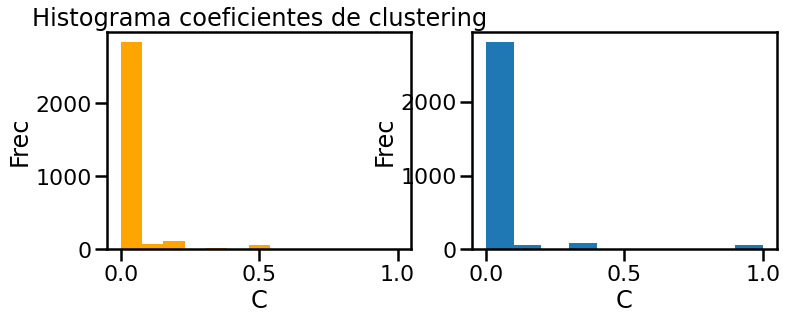

In [171]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.hist(nx.clustering(G1).values(),bins='auto',color='orange');
plt.xlabel('C')
plt.ylabel('Frec')
plt.title('Histograma coeficientes de clustering')
plt.subplot(122)
plt.hist(nx.clustering(G2).values());
plt.xlabel('C')
plt.ylabel('Frec')




Aqui se ve que en la mayoria de casos los vecinos de los nodos no estan conectados entre si. En la segunda red hay unos pocos nodos muy conectados.


Asortividad (selectividad)

In [172]:
nx.degree_assortativity_coefficient(G1), nx.degree_assortativity_coefficient(G2)

(0.00040708159721905985, -0.08068592003843007)

la primera red es no asortativa, la segunda es disasortativa, es decir los nodos conectados difieren mucho en sus grados

# Grado

Grados por nodo

In [173]:
df_grados_1 = pd.DataFrame(G1.degree,columns=['Node','Degree']).set_index('Node')
df_grados_1.sort_values('Degree',ascending=False).T

Node,money,green,sex,food,love,water,me,work,good,car,house,paper,man,red,fruit,death,old,sad,hair,smart,clean,black,baby,fire,words,up,stop,ball,blue,bright,yes,white,mean,woman,word,apple,child,way,tree,gross,...,racquetball,aghast,ahead,chart,feedback,picky,feeding,aircraft,skater,peace,payday,alone,potion,pots,powerful,fabric,accuse,achieve,quantity,quack,purchase,acting,drug,excitement,exciting,click,exercise,clever,defend,prompt,clay,chuckle,produce,processing,extend,adults,prison,advantage,preach,walking
Degree,44,31,30,27,25,24,22,22,21,21,20,19,19,18,17,17,16,15,14,14,14,14,14,14,14,13,13,13,13,13,13,13,13,12,12,12,12,12,12,12,...,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


In [174]:
df_grados_2 = pd.DataFrame(G2.degree,columns=['Node','Degree']).set_index('Node')
df_grados_2.sort_values('Degree',ascending=False).T

Node,money,green,sex,food,love,car,water,paper,house,good,work,me,fruit,death,clean,man,sad,fire,baby,red,old,black,yes,stop,up,blue,time,word,mean,ball,talk,funny,bird,hair,color,gross,day,dirty,boat,child,...,snooze,gal,rifle,biology,picky,wish,chart,bind,guide,bike,larger,plains,moan,beverage,plaything,wind,hallway,peace,handwriting,paid,division,patient,documents,boost,heels,occur,paragraph,bonus,donor,payment,partner,knob,bold,boisterous,bog,handcuffs,boastful,boa,payday,file
Degree,34,25,23,22,19,19,19,19,18,17,17,16,15,14,13,13,13,13,13,12,12,12,11,11,11,11,11,11,10,10,10,10,10,10,10,10,10,10,10,10,...,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


Viendolos en un histograma

<Figure size 576x288 with 0 Axes>

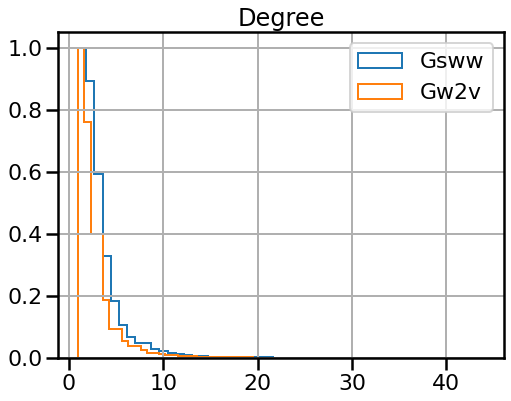

In [177]:
plt.figure(figsize=(8,4));
df_grados_1.hist(density=True,histtype='step',label='Gsww',bins=50,cumulative=-1);
df_grados_2.hist(density=True,ax=plt.gca(), histtype='step',label='Gw2v',bins=50,cumulative=-1);
plt.legend();

Probando si ajustan con una power law.

Red Gsww:

In [185]:
results1 = powerlaw.Fit(df_grados_1['Degree'],discrete=True,)
R1,p1 = results1.distribution_compare('power_law', 'exponential')

Calculating best minimal value for power law fit


Una exponencial evidentemente no ajusta

In [192]:
# si el primer numero es grande, la distribucion mas probable es la primera candidata
print(R1,p1)

30.835718768071473 0.009650825324647868


Exponente de la ley de potencias y desviacion estandar

In [193]:
results1.power_law.alpha, results1.power_law.sigma

(3.6717452005603217, 0.11171127883716807)

Text(0.5, 0, 'grado')

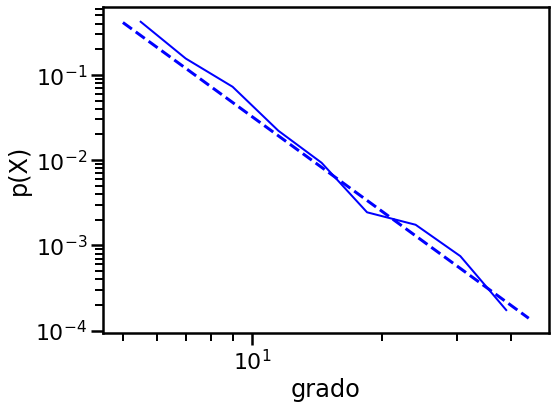

In [195]:
figPDF = results1.plot_pdf(color='b', linewidth=2)
results1.power_law.plot_pdf(color='b', linestyle='--', ax=figPDF)

####
figPDF.set_ylabel(u"p(X)")
figPDF.set_xlabel(r"grado")

Red Gw2v

In [196]:
results2 = powerlaw.Fit(df_grados_2['Degree'],discrete=True,)
R2,p2 = results2.distribution_compare('power_law', 'exponential')

Calculating best minimal value for power law fit


In [197]:
# si el primer numero es grande, la distribucion mas probable es la primera candidata
print(R2,p2)

33.969473953549354 0.0028434191510044423


Esta tampoco ajustaria con una exponencial

In [198]:
results2.power_law.alpha, results2.power_law.sigma


(3.5542161662788403, 0.10755190256254424)

Text(0.5, 0, 'grado')

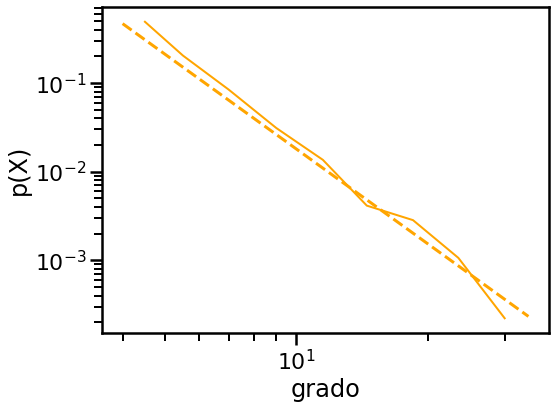

In [199]:
figPDF = results2.plot_pdf(color="orange", linewidth=2)
results2.power_law.plot_pdf(color="orange", linestyle='--', ax=figPDF)

####
figPDF.set_ylabel(u"p(X)")
figPDF.set_xlabel(r"grado")

Las distribuciones de grado comparadas:

Ambas aunque son de mundo pequeño ajustan con una ley de potencias. Puede ser que al recortar la red se hayan quitado shorcuts, o que la red filtrada solo para las edades, pais e idioma elegido tengan mas esta distribucion

In [ ]:
#demora
#omega = nx.algorithms.smallworld.omega(G1, niter=60, nrand=4)

# Medidas de centralidad

Centralidad de grado

In [201]:
 pos_1 = nx.spring_layout(G1,k=0.2)
 pos_2 = nx.spring_layout(G2,k=0.2)

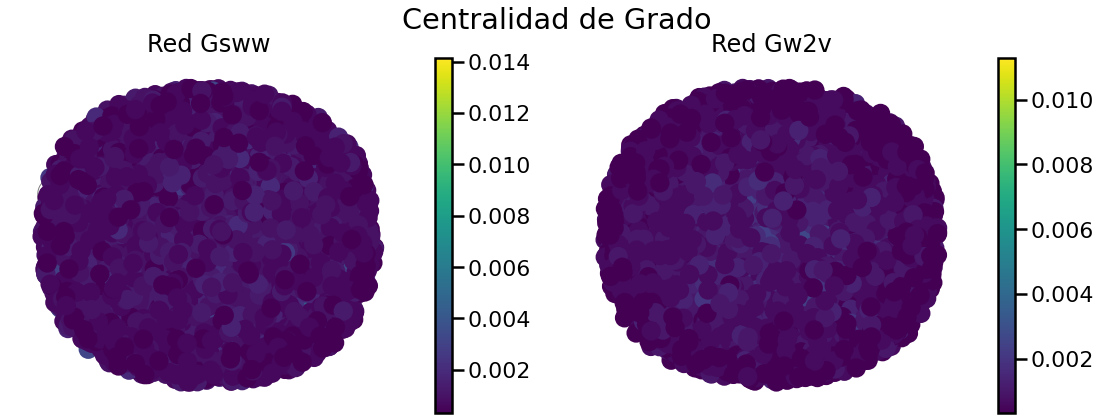

In [202]:
fig, axs = plt.subplots(1,2,figsize=(16,6))

centrality = nx.degree_centrality(G1)
values = [v for n,v in centrality.items()]
nx.draw(G1,pos=pos_1, with_labels=False,node_color = values, font_color='white', edge_color='gray',ax=axs[0])
sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=min(values), vmax=max(values))); sm.set_array([]); cbar = plt.colorbar(sm,ax=axs[0])
axs[0].set_title('Red Gsww');

centrality = nx.degree_centrality(G2)
values = [v for n,v in centrality.items()]
nx.draw(G2,pos=pos_2, with_labels=False,node_color = values, font_color='white', edge_color='gray',ax=axs[1])
axs[1].set_title('Red Gw2v');
sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=min(values), vmax=max(values))); sm.set_array([]); cbar = plt.colorbar(sm,ax=axs[1])

plt.suptitle('Centralidad de Grado',y=1.0)
plt.tight_layout();

Como sale muy fea esta visualizacion, grafico el histograma de centralidades

In [203]:
degCent1 = nx.degree_centrality(G1)
degCent2 = nx.degree_centrality(G2)
print(min(degCent1.values()),max(degCent1.values()))
print(min(degCent2.values()),max(degCent2.values()))

0.00032175032175032174 0.014157014157014156
0.00033211557622052476 0.011291929591497841


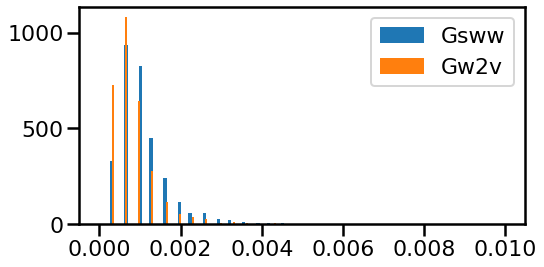

In [208]:

plt.figure(figsize=(8,4));
out1 = plt.hist(degCent1.values(),bins='auto',range=[0,0.01],label = 'Gsww')
out2 = plt.hist(degCent2.values(),bins='auto',range=[0,0.01],label = 'Gw2v')
plt.legend()

Ambas redes tienen nodos con centralidades pequeñas. La Gsww tiene mas nodos con centralidad ¨grande¨ que la Gw2v y centralidades mas ¨grandes¨

Las otras tres centralidades demoran, no correr.

Centralidad de betweeness

In [ ]:
fig, axs = plt.subplots(1,2,figsize=(16,6))

centrality = nx.betweenness_centrality(G1)
values = [v for n,v in centrality.items()]
nx.draw(G1,pos=pos_1, with_labels=True, font_weight='bold',node_color = values, font_color='white', edge_color='gray',ax=axs[0])
sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=min(values), vmax=max(values))); sm.set_array([]); cbar = plt.colorbar(sm,ax=axs[0])
axs[0].set_title('Red Gsww');

centrality = nx.betweenness_centrality(G2)
values = [v for n,v in centrality.items()]
nx.draw(G2,pos=pos_2, with_labels=True, font_weight='bold',node_color = values, font_color='white', edge_color='gray',ax=axs[1])
axs[1].set_title('Red Gw2v');
sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=min(values), vmax=max(values))); sm.set_array([]); cbar = plt.colorbar(sm,ax=axs[1])
plt.suptitle('Centralidad de Betweenness',y=1.0);
plt.tight_layout();

  Centralidad de cercania

In [ ]:
fig, axs = plt.subplots(1,2,figsize=(16,6))

centrality = nx.closeness_centrality(G1)
values = [v for n,v in centrality.items()]
nx.draw(G1,pos=pos_1, with_labels=False,node_color = values, font_color='white', edge_color='gray',ax=axs[0])
sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=min(values), vmax=max(values))); sm.set_array([]); cbar = plt.colorbar(sm,ax=axs[0])
axs[0].set_title('Red Gsww');

centrality = nx.closeness_centrality(G2)
values = [v for n,v in centrality.items()]
nx.draw(G2,pos=pos_1, with_labels=False,node_color = values, font_color='white', edge_color='gray',ax=axs[1])
axs[1].set_title('Red Gw2v');
sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=min(values), vmax=max(values))); sm.set_array([]); cbar = plt.colorbar(sm,ax=axs[1])
plt.suptitle('Centralidad de Cercanía',y=1.0);
plt.tight_layout();

Centralidad de autovector

In [ ]:
fig, axs = plt.subplots(1,2,figsize=(16,6))

centrality = nx.eigenvector_centrality(G1)
values = [v for n,v in centrality.items()]
nx.draw(G1,pos=pos_1, with_labels=False, font_weight='bold',node_color = values, font_color='white', edge_color='gray',ax=axs[0])
sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=min(values), vmax=max(values))); sm.set_array([]); cbar = plt.colorbar(sm,ax=axs[0])
axs[0].set_title('Red observada');

centrality = nx.eigenvector_centrality(G_2)
values = [v for n,v in centrality.items()]
nx.draw(G2,pos=pos_2, with_labels=False, font_weight='bold',node_color = values, font_color='white', edge_color='gray',ax=axs[1])
axs[1].set_title('Red percibida');
sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=min(values), vmax=max(values))); sm.set_array([]); cbar = plt.colorbar(sm,ax=axs[1])
plt.suptitle('Centralidad de Autovector',y=1.0);
plt.tight_layout();

# Deteccion de comunidades

In [209]:
from networkx.algorithms.community import modularity
import community.community_louvain as community_louvain

Deteccion con algoritmo de Louvain

Como G1 dio dirigido, no se calcula con este algoritmo las comunidades

In [ ]:
#modulos1 = community_louvain.best_partition(G1)
#values_1 = [v for n,v in modulos1.items()]
#nx.draw(G1,pos=pos_1, with_labels=False,cmap=plt.cm.tab10,node_color = values_1, edge_color='gray')

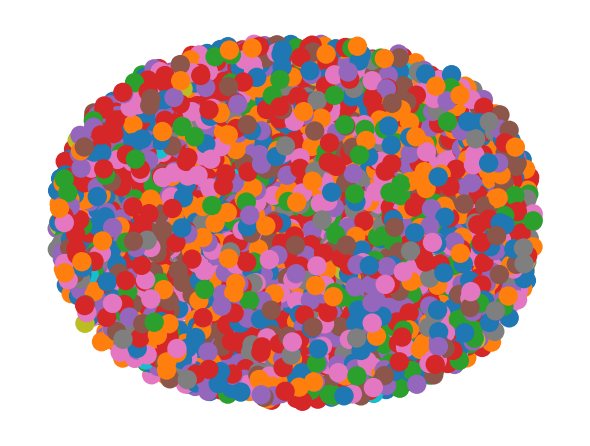

In [212]:
modulos2 = community_louvain.best_partition(G2)
values_2 = [v for n,v in modulos2.items()]
nx.draw(G2,pos=pos_2, with_labels=False,cmap=plt.cm.tab10,node_color = values_2, edge_color='gray')

# Comparacion con redes small world

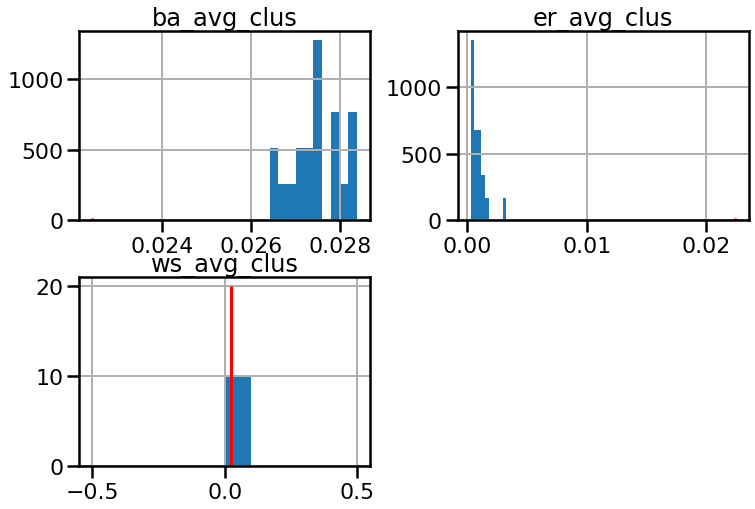

In [217]:
repetitions = 20
dat = []
for i in range(repetitions):
    d = {}
    G_pl = nx.barabasi_albert_graph(G2.number_of_nodes(),10,seed=i)
    d['ba_avg_clus'] = nx.average_clustering(G_pl)
    #d['ba_avg_path'] = nx.average_shortest_path_length(G_pl)
    d['ba_avg_degree'] = G_pl.number_of_edges()/G_pl.number_of_nodes()
    d['ba_alpha'] = powerlaw.Fit([d for n, d in G_pl.degree],discrete=True,xmin=8).alpha

    G_r = nx.gnm_random_graph(G1.number_of_nodes(),G1.number_of_edges(),seed=i)    
    d['er_avg_clus'] = nx.average_clustering(G_r)
    #d['er_avg_path'] = nx.average_shortest_path_length(G_r)
    
    G_sw = nx.newman_watts_strogatz_graph(G1.number_of_nodes(),round(G1.number_of_edges()/G1.number_of_nodes()),0.03,seed=i)
    d['ws_avg_clus'] = nx.average_clustering(G_sw)
    #d['ws_avg_path'] = nx.average_shortest_path_length(G_sw)
    dat.append(d)

df_s = pd.DataFrame(dat)
axs = df_s.filter(regex='avg_clus').hist(figsize=(12,8),density=True)
for ax in axs.flatten():
    ax.vlines(nx.average_clustering(G1),0,20,lw=3,color='r')

#axs = df_s.filter(regex='avg_path').hist(figsize=(12,8),density=True)
#for ax in axs.flatten():
    #ax.vlines(nx.average_shortest_path_length(G1),0,20,lw=3,color='r')